## Preprocess

In [1]:
import jsonlines
import pandas
import json
# Load the data from the JSON line file
with open('../data/kotlin-public.jsonl', 'r') as f:
    dataframe = pandas.DataFrame([json.loads(line) for line in f])

In [2]:
import os
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
DATA_ROOT = "../data/repositories-kotlin-public/"



def extract_original_code_from_row(row: pandas.Series) -> str:
    """
    Extract the original code from the file path.
    """
    repo_path = os.path.join(DATA_ROOT, "-".join([row["repo"].replace("/", "__"), row['revision']]))
    file_path = repo_path + "/" + row['path']
    with open(file_path, 'r') as file:
        content = file.read()
    return content

dataframe['original_code'] = dataframe.apply(extract_original_code_from_row, axis=1)
dataframe['incomplete_code'] = dataframe.apply(lambda row: SEPARATOR_COMMENT.join([row['prefix'], row['suffix']]), axis=1)


In [3]:
import diff_match_patch

def extract_diff_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the diff from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.diff_lineMode(original_code, incomplete_code, deadline=None)
    # Convert the diffs to a single diff string
    diffs = "\n".join([diff[1] for diff in diffs if diff[0] != 0])
    return diffs

def extract_patch_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the patch from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.patch_make(original_code, incomplete_code)
    # Convert the patches to a single patch string
    patches = dmp.patch_toText(diffs)
    return patches




In [4]:
for index, row in dataframe.iterrows():
    output_root = "../samples-public/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    dir_name = os.path.join(output_root, repo_revision)
    os.makedirs(dir_name, exist_ok=True)
    original_file_path = os.path.join(dir_name, "original.kt")
    incomplete_file_path = os.path.join(dir_name, "incomplete.kt")
    diff_file_path = os.path.join(dir_name, "diff.diff")
    patch_file_path = os.path.join(dir_name, "patch.patch")
    
    
    with open(original_file_path, 'w') as original_file:
        original_file.write(row['original_code'])
    with open(incomplete_file_path, 'w') as incomplete_file:
        incomplete_file.write(row['incomplete_code'])
    with open(diff_file_path, 'w') as diff_file:
        diff_file.write(extract_diff_from_original_code_and_incomplete_code(row))
    with open(patch_file_path, 'w') as patch_file:
        patch_file.write(extract_patch_from_original_code_and_incomplete_code(row))
    
    dataframe.at[index, 'diff'] = extract_diff_from_original_code_and_incomplete_code(row)
    dataframe.at[index, 'patch'] = extract_patch_from_original_code_and_incomplete_code(row)

        


In [5]:

def extract_diff_prefix_and_suffix(row: pandas.Series) -> tuple[str, str]:
    """
    Extract the prefix and suffix from the diff.
    """
    diff = row['diff']
    splitted = diff.split(SEPARATOR_COMMENT)
    if len(splitted) < 2:
        return splitted[0], ""
    return splitted[0], splitted[1]

In [6]:
for index, row in dataframe.iterrows():
    output_root = "../samples-public/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    diff_prefix, diff_suffix = extract_diff_prefix_and_suffix(row)
    dataframe.at[index, 'diff_prefix'] = diff_prefix
    dataframe.at[index, 'diff_suffix'] = diff_suffix
    prefix, suffix = row['prefix'], row['suffix']
    with open(os.path.join(output_root, repo_revision, "diff_prefix.kt"), 'w') as f:
        f.write(diff_prefix)
    with open(os.path.join(output_root, repo_revision, "diff_suffix.kt"), 'w') as f:
        f.write(diff_suffix)
    with open(os.path.join(output_root, repo_revision, "prefix.kt"), 'w') as f:
        f.write(prefix)
    with open(os.path.join(output_root, repo_revision, "suffix.kt"), 'w') as f:
        f.write(suffix)

## Syntax tree analysis

In [12]:
# Let's create a simple example to demonstrate the tree-sitter query matching
import tree_sitter
from tree_sitter_languages import get_language
# Sample Kotlin code
kotlin_code = """
class Person(val name: String) {
    var age: Int = 0
    
    fun getInfo(): String {
        return "Name: $name, Age: $age"
    }
    
    // This is a comment
    @Override
    fun toString() = "Person(name=$name)"
}
"""

# Create a parser
parser = tree_sitter.Parser()
parser.set_language(get_language("kotlin"))

# Parse the code
tree = parser.parse(bytes(kotlin_code, "utf8"))

# Print the syntax tree
print(tree.root_node.sexp())

(source_file (class_declaration name: (type_identifier) primary_constructor: (primary_constructor parameters: (class_parameter (simple_identifier) (user_type (type_identifier)))) body: (class_body (property_declaration variable: (variable_declaration (simple_identifier) (user_type (type_identifier))) expression: (integer_literal)) (function_declaration name: (simple_identifier) parameters: (function_value_parameters) return_type: (user_type (type_identifier)) body: (function_body (statements (jump_expression (string_literal (interpolated_identifier) (interpolated_identifier)))))) (line_comment) (function_declaration modifiers: (modifiers (annotation (user_type (type_identifier)))) name: (simple_identifier) parameters: (function_value_parameters) body: (function_body (string_literal (interpolated_identifier)))))))


In [13]:
def highlight_matches(code: str, query_string: str):
    """
    Highlight matches from a tree-sitter query in the given code
    """
    # Create a query
    language = get_language("kotlin")
    query = language.query(query_string)
    
    # Get matches
    tree = parser.parse(bytes(code, "utf8"))
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return
    
    
    # Print matches with their capture types
    for match in matches:
        print(match)

In [14]:
# Let's try some specific queries

# Find all function declarations
function_query = """
(function_declaration 
    . (simple_identifier) @function_name) @function
"""
print("Function declarations:")
highlight_matches(kotlin_code, function_query)

# Find class declarations
class_query = """(class_declaration
    (simple_identifier) @class_name) @class
"""

# Find class properties
property_query = """
(class_parameter
    (simple_identifier) @property)
(class_body
    (property_declaration
        (variable_declaration
            (simple_identifier) @property)))
"""
print("\nProperties:")
highlight_matches(kotlin_code, property_query)

Function declarations:
(<Node type=function_declaration, start_point=(4, 4), end_point=(6, 5)>, 'function')
(<Node type=simple_identifier, start_point=(4, 8), end_point=(4, 15)>, 'function_name')
(<Node type=function_declaration, start_point=(9, 4), end_point=(10, 41)>, 'function')

Properties:
(<Node type=simple_identifier, start_point=(1, 17), end_point=(1, 21)>, 'property')
(<Node type=simple_identifier, start_point=(2, 8), end_point=(2, 11)>, 'property')


In [15]:
# Function to analyze package and import relationships
def analyze_package_imports(code: str) -> tuple[str, list[str]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    
    # Parse the code
    language = get_language("kotlin")
    tree = parser.parse(bytes(code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node.text.decode("utf-8"))

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[str]) -> list[str]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.split('.')[0] == root_package
    ]
    
    return same_repo_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports:")
for imp in imports:
    print(f"  {imp}")

same_repo_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp}")

Package: fe.linksheet.module.resolver

Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat


## Token-level Analysis

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JetBrains/Mellum-4b-sft-kotlin")


/Users/minhna1112/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print(tokenizer.encode(kotlin_code))

NameError: name 'kotlin_code' is not defined

In [9]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_prefix_tokens'] = dataframe['prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens'] = dataframe['suffix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_diff_tokens'] = dataframe['diff'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_prefix_tokens_in_diff'] = dataframe['diff_prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens_in_diff'] = dataframe['diff_suffix'].apply(lambda x : len(code_to_tokens(x)))

Text(0, 0.5, 'Frequency')

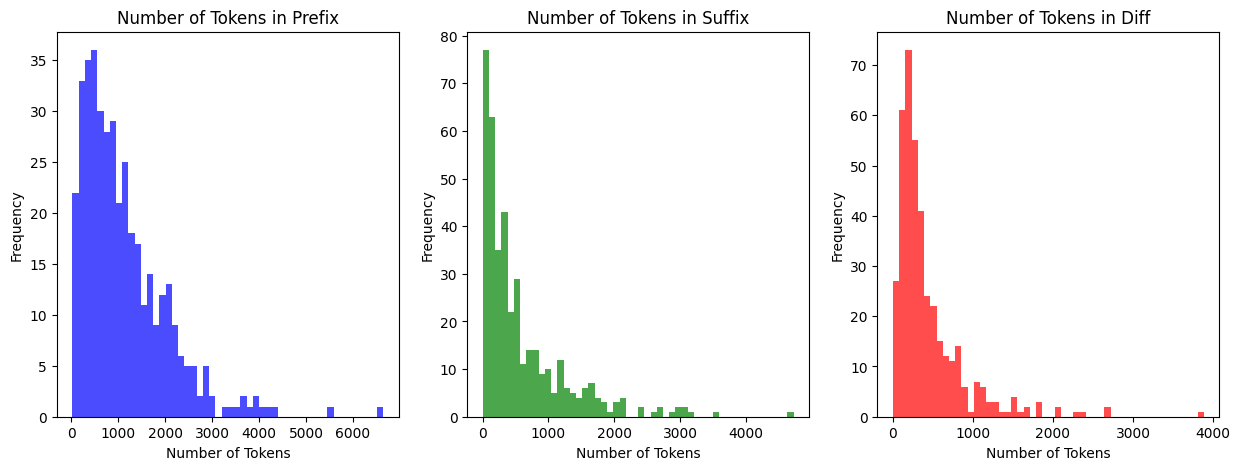

In [11]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

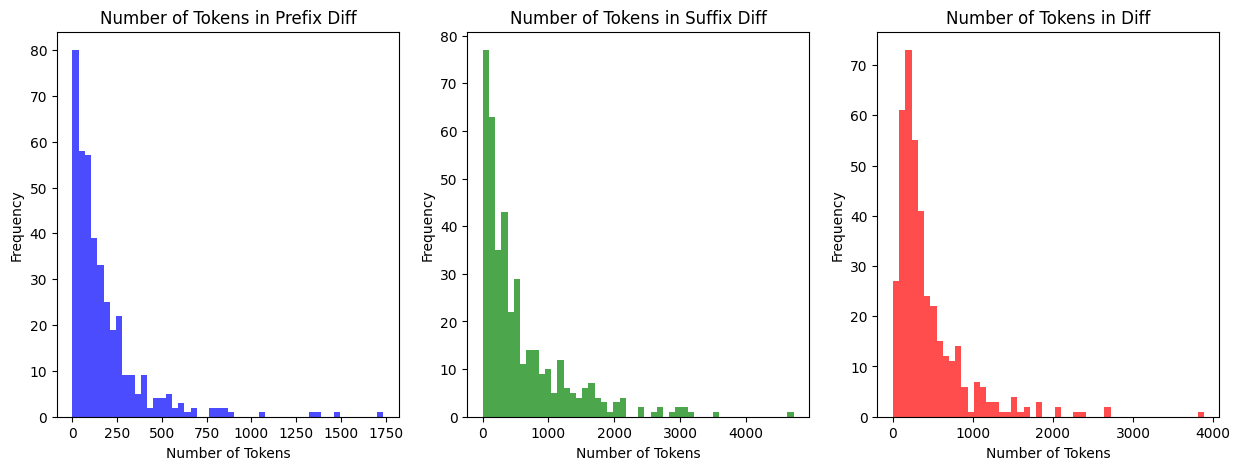

In [12]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_in_diff'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [22]:
def remove_comments_nodes(code: str)->str:
    """
    Remove comments from the code using tree-sitter
    """
    language = get_language("kotlin")
    parser = tree_sitter.Parser()
    parser.set_language(language)
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    # Parse the code
    tree = parser.parse(bytes(cleaned_code, "utf8"))

    # Query to find comment nodes
    query_str = """
    (line_comment) @comment
    (multiline_comment) @comment
    """
    
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    
    # Remove comment nodes from the code
    
    for match in matches:
        node = match[0]
        cleaned_code = cleaned_code[:node.start_byte] + cleaned_code[node.end_byte:]

    return cleaned_code

dataframe['prefix_without_comments'] = dataframe['prefix'].apply(
    remove_comments_nodes
)

dataframe['suffix_without_comments'] = dataframe['suffix'].apply(
    remove_comments_nodes
)
dataframe['diff_without_comments'] = dataframe['diff'].apply(
    remove_comments_nodes
)



Text(0.5, 1.0, 'Number of Tokens in Diff')

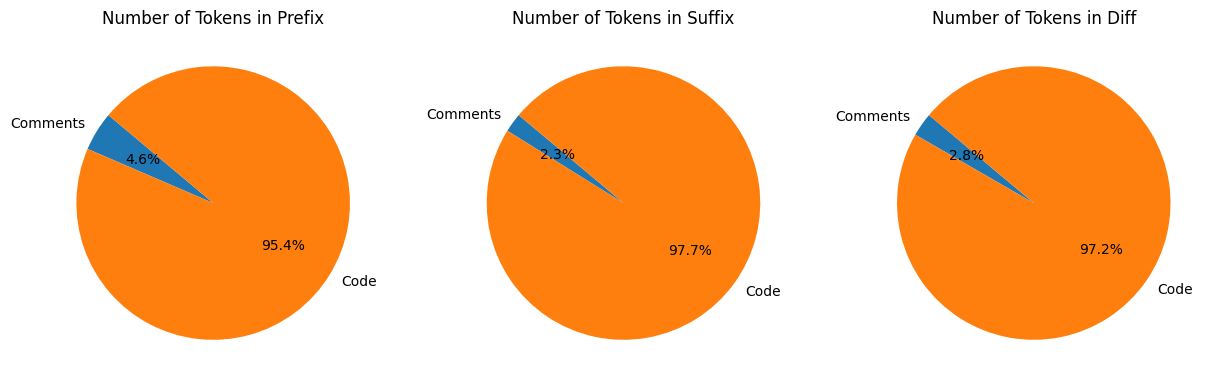

In [23]:
dataframe["num_prefix_tokens_without_comments"] = dataframe['prefix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_suffix_tokens_without_comments"] = dataframe['suffix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_diff_tokens_without_comments"] = dataframe['diff_without_comments'].apply(lambda x : len(code_to_tokens(x)))

# plot 3 pie charts of the number of tokens  between code and comments (original - code) in prefix, suffix, and diff

import matplotlib.pyplot as plt

labels = ['Comments', 'Code']
prefix_sizes = [
    dataframe['num_prefix_tokens'].sum() - dataframe['num_prefix_tokens_without_comments'].sum(),
    dataframe['num_prefix_tokens_without_comments'].sum()
]
suffix_sizes = [
    dataframe['num_suffix_tokens'].sum() - dataframe['num_suffix_tokens_without_comments'].sum(),
    dataframe['num_suffix_tokens_without_comments'].sum()
]
diff_sizes = [
    dataframe['num_diff_tokens'].sum() - dataframe['num_diff_tokens_without_comments'].sum(),
    dataframe['num_diff_tokens_without_comments'].sum()
]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(prefix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Prefix')
plt.subplot(1, 3, 2)
plt.pie(suffix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Suffix')
plt.subplot(1, 3, 3)
plt.pie(diff_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Diff')


Text(0, 0.5, 'Frequency')

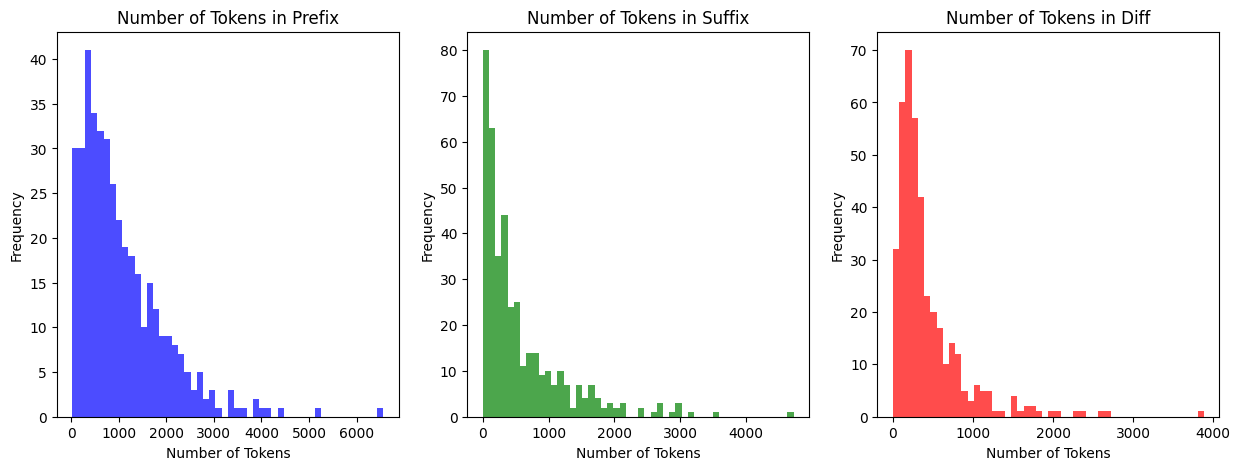

In [24]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff (after removing comments)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_without_comments'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens_without_comments'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens_without_comments'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

### Import Analysis



In [25]:
# Function to analyze package and import relationships
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
def analyze_package_imports(code: str) -> tuple[str, list[Node]]:
    """
    Analyze a Kotlin file to extract its package and imports,
    returning the package name and list of import statements
    """
    # Query to capture package and import identifiers
    query_str = """
    (package_header
        (identifier) @package)
        
    (import_header
        (identifier) @import)
    """
    parser = get_parser("kotlin")
    # Parse the code
    language = get_language("kotlin")
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(cleaned_code, "utf8"))
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    if not matches:
        print("No matches found.")
        return "", []
    package_name = ""
    imports = []
    
    for (node, node_name) in matches:
        if node_name == "package":
            package_name= node.text.decode("utf-8")
        elif node_name == "import":
            imports.append(node)

    return package_name, imports

def check_same_repository_imports(package_name: str, imports: list[Node]) -> list[Node]:
    """
    Check which imports are from the same repository as the package
    by comparing their root package names
    """
    # Get the root package (first component)
    root_package = package_name.split('.')[0]
    
    # Find imports that start with the same root package
    same_repo_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] == root_package
    ]
    external_imports = [
        imp for imp in imports
        if imp.text.decode("utf-8").split('.')[0] != root_package
    ]

    return same_repo_imports, external_imports

# Test with the sample code
sample_kotlin = '''package fe.linksheet.module.resolver
import android.content.Context
import android.content.Intent
import android.content.IntentFilter
import android.content.IntentFilter.AuthorityEntry
import android.content.pm.PackageManager
import android.content.pm.ResolveInfo
import android.content.pm.queryIntentActivitiesCompat
import android.net.Uri
import fe.linksheet.util.BitFlagUtil
import fe.linksheet.util.LinkSheetCompat
'''

package_name, imports = analyze_package_imports(sample_kotlin)
print(f"Package: {package_name}")

same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
print("\nImports from same repository:")

def remove_import_nodes(code: str, import_nodes: list[Node]) -> str:
    """
    Remove import statements from the code using tree-sitter
    """
    for node in import_nodes:
        code = code[:node.start_byte] + code[node.end_byte:]

    return code



for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")

print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}")


# A function to at the same time identify pakage name, extract in-repository and external imports, and remove import nodes from prefix
def analyze_and_clean_imports(code: str) -> tuple[str, list[str], list[str], str]:
    """
    Analyze the code to extract package name, in-repository imports, external imports,
    and return the cleaned code without import statements.
    """
    package_name, imports = analyze_package_imports(code)
    same_repo_imports, external_imports = check_same_repository_imports(package_name, imports)
    cleaned_code = remove_import_nodes(code, same_repo_imports)
    return package_name, same_repo_imports, external_imports, cleaned_code

package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(sample_kotlin)
print(f"Package: {package_name}")
print("\nImports from same repository:")
for imp in same_repo_imports:
    print(f"  {imp.text.decode('utf-8')}")
print("\nExternal Imports:")
for imp in external_imports:
    print(f"  {imp.text.decode('utf-8')}") 
print("\nCleaned Code:")


Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri
Package: fe.linksheet.module.resolver

Imports from same repository:
  fe.linksheet.util.BitFlagUtil
  fe.linksheet.util.LinkSheetCompat

External Imports:
  android.content.Context
  android.content.Intent
  android.content.IntentFilter
  android.content.IntentFilter.AuthorityEntry
  android.content.pm.PackageManager
  android.content.pm.ResolveInfo
  android.content.pm.queryIntentActivitiesCompat
  android.net.Uri

Cleaned Code:


In [26]:
for index, row in dataframe.iterrows():
    package_name, same_repo_imports, external_imports, cleaned_code = analyze_and_clean_imports(row.prefix)
    dataframe.at[index, 'package_name'] = package_name
    dataframe.at[index, 'same_repo_imports'] = [imp.text.decode('utf-8') for imp in same_repo_imports]
    dataframe.at[index, 'external_imports'] = [imp.text.decode('utf-8') for imp in external_imports]
    dataframe.at[index, 'prefix_without_imports'] = cleaned_code

ValueError: Must have equal len keys and value when setting with an iterable

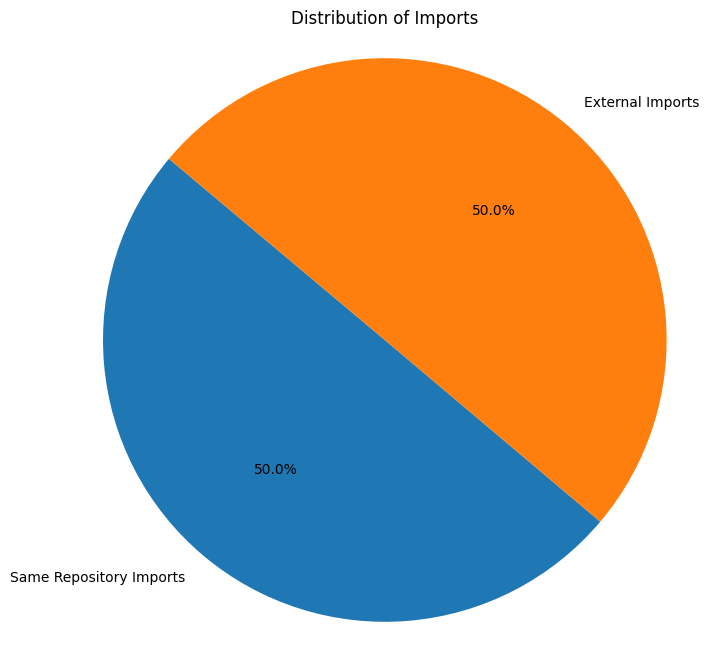

In [ ]:
# pie charts of the number of imports in same repository and external imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(len).sum().astype(int)
external_counts = dataframe['external_imports'].apply(len).sum().astype(int)
sizes = [same_repo_counts, external_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# pie charts of the number of tokens of imports in same repository and external imports, and the prefix without imports
import matplotlib.pyplot as plt
labels = ['Same Repository Imports', 'External Imports', 'Prefix Without Imports']
same_repo_counts = dataframe['same_repo_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
external_counts = dataframe['external_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
prefix_counts = dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))).sum()
sizes = [same_repo_counts, external_counts, prefix_counts]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Imports')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

AttributeError: 'list' object has no attribute 'replace'

KeyError: 'prefix_without_imports'

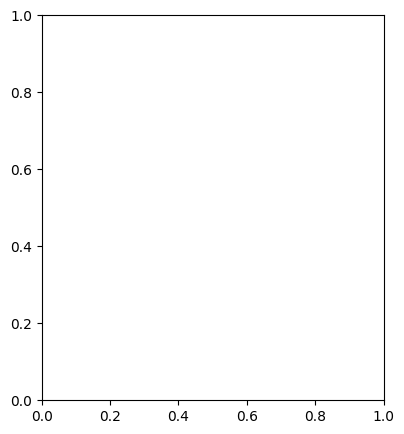

In [ ]:
# 3 histograms of the number of tokens in prefix (after removing imports), suffix, and diff 
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['prefix_without_imports'].apply(lambda x: len(code_to_tokens(x))), bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

### Localize Completion Point

In [13]:
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
# using tree-sitter to find multi-line comment nodes in the diff
import re
import pandas
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
def detect_completion_point(row) -> tuple[int, int]:
    """
    Detect the completion point by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["prefix"], "utf8"))
    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def detect_completion_point_in_diff(row: pandas.Series) -> tuple[int, int]:
    """
    Detect the completion point in the diff by taking the end point of the prefix.
    """
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(row["diff_prefix"], "utf8"))

    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def localize_outer_symbol_from_completion_point(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["incomplete_code"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]
    
    completion_point = detect_completion_point(row)
    
    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)


def localize_outer_symbol_from_completion_point_in_diff(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("kotlin")
    incomplete_code = row["diff"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../kotlin_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("kotlin").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]

    completion_point = detect_completion_point_in_diff(row)

    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)

In [14]:
dataframe['completion_point'] = dataframe.apply(detect_completion_point, axis=1)
dataframe['completion_point_in_diff'] = dataframe.apply(detect_completion_point_in_diff, axis=1)

In [35]:
dataframe['container_symbol_type'].value_counts()

container_symbol_type
class_declaration       42
call_expression         20
function_declaration    18
object_declaration       7
class_body               6
lambda_literal           3
Name: count, dtype: int64

<Axes: title={'center': 'Container Symbol Type Distribution'}, ylabel='count'>

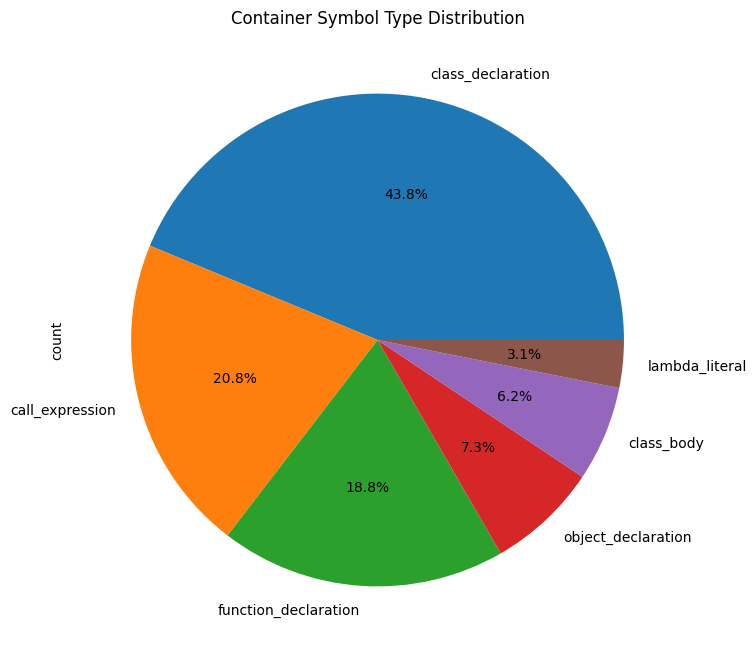

In [37]:

dataframe['container_symbol_type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Container Symbol Type Distribution')

In [35]:
dataframe['num_tokens_container_symbol'].hist(bins=50, color='blue', alpha=0.7)

KeyError: 'num_tokens_container_symbol'

In [2]:
dataframe['num_diff_tokens'].median()

NameError: name 'dataframe' is not defined

In [40]:
dataframe.to_csv("../data/kotlin_public_analyzed.csv", index=False)

## Diff Analysis

### Zoekt


In [17]:
import requests
import json

url = "http://localhost:6070/api/search"

payload = json.dumps({
  "Q": "fun rgb  r:aivanovski__keepassvault",
  "Opts": {
    "NumContextLines": 5,
    "MaxResults": 10,
  }
})
headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)


{"Result":{"ContentBytesLoaded":16988,"IndexBytesLoaded":6777,"Crashes":0,"Duration":119219750,"FileCount":4,"ShardFilesConsidered":0,"FilesConsidered":4,"FilesLoaded":4,"FilesSkipped":0,"ShardsScanned":2,"ShardsSkipped":0,"ShardsSkippedFilter":18,"MatchCount":34,"NgramMatches":34,"NgramLookups":816,"Wait":44958,"MatchTreeConstruction":541931957,"MatchTreeSearch":47257208,"RegexpsConsidered":0,"FlushReason":0,"Files":[{"FileName":"app/src/main/kotlin/com/ivanovsky/passnotes/presentation/history/cells/ui/HistoryDiffCell.kt","Repository":"aivanovski__keepassvault-b46ff7ad158a1e86c29ea2fc46dd8d7af2d8d52f","Language":"Kotlin","LineMatches":[{"Line":"aW1wb3J0IGFuZHJvaWR4LmNvbXBvc2UudWkuZ3JhcGhpY3MudG9BcmdiCg==","LineStart":709,"LineEnd":752,"LineNumber":17,"Before":"aW1wb3J0IGFuZHJvaWR4LmNvbXBvc2UubWF0ZXJpYWwzLkNhcmREZWZhdWx0cwppbXBvcnQgYW5kcm9pZHguY29tcG9zZS5tYXRlcmlhbDMuVGV4dAppbXBvcnQgYW5kcm9pZHguY29tcG9zZS5ydW50aW1lLkNvbXBvc2FibGUKaW1wb3J0IGFuZHJvaWR4LmNvbXBvc2UudWkuTW9kaWZpZXIKaW1wb3J0

In [18]:
import json

searched_files = json.loads(response.text)['Result']['Files']

In [20]:
import base64

def decode_line(line: str) -> str:
    """
    Decode a base64 encoded line.
    """
    return base64.b64decode(line).decode('utf-8')

matches = searched_files[0]['LineMatches']
# matches.sort(key=lambda x: x['LineNumber'])
code_snippets = ["".join([decode_line(match['Before']), decode_line(match['Line']), decode_line(match['After'])]) for match in matches]

In [21]:
code_snippets

['import androidx.compose.material3.CardDefaults\nimport androidx.compose.material3.Text\nimport androidx.compose.runtime.Composable\nimport androidx.compose.ui.Modifier\nimport androidx.compose.ui.graphics.Color\nimport androidx.compose.ui.graphics.toArgb\nimport androidx.compose.ui.platform.LocalDensity\nimport androidx.compose.ui.res.dimensionResource\nimport androidx.compose.ui.tooling.preview.Preview\nimport androidx.compose.ui.unit.dp\nimport com.ivanovsky.passnotes.R\n',
 'import com.ivanovsky.passnotes.presentation.history.cells.viewModel.HistoryDiffCellViewModel\nimport com.ivanovsky.passnotes.util.StringUtils\nimport com.ivanovsky.passnotes.util.toRoundedCornerShape\n\n@Composable\nfun HistoryDiffCell(viewModel: HistoryDiffCellViewModel) {\n    val cornerRadius = LocalDensity.current.run {\n        dimensionResource(R.dimen.card_corner_radius).toPx()\n    }\n\n    Card(\n',
 '    }\n}\n\n@Preview\n@Composable\nfun LightDiffCellPreview() {\n    ThemedScreenPreview(theme = Ligh

In [49]:
from typing import List



def process_navigation_expression(s: str, case_sensitive: bool) -> str:
    s =  "".join(c if c.isalnum() else " " for c in s)
    s = ".".join(s.strip().replace("\n", " ").replace("  ", " ").split())    
    s = s.lower() if not case_sensitive else s
    return s

def process_navigation_expressions(navigation_expressions: List[str], case_sensitive: bool) -> List[str]:
    navigation_expressions = list(set(navigation_expressions))  # Remove duplicates
    return [process_navigation_expression(expr, case_sensitive) for expr in navigation_expressions]

def filter_and_rank_identifiers(identifiers: List[str], maximum_terms: int) -> List[str]:
     # rank identifiers by their frequency in the code snippet
    identifier_counts = {identifier: identifiers.count(identifier) for identifier in identifiers}
    identifiers = sorted(identifiers, key=lambda x: identifier_counts[x], reverse=True)
    identifiers = list(set(identifiers))
    # Limit to maximum_terms
    return identifiers[:maximum_terms]

def get_all_function_and_class_names(code_snippet: str) -> List[str]:
    """
    Extract all function and class names from a code snippet.
    """
    language = get_language("kotlin")
    ts_query = """"""
    with open("../kotlin_symbols_identifiers.scm", "r") as f:
        ts_query = f.read()
    parser = get_parser("kotlin")
    tree = parser.parse(bytes(code_snippet, "utf8"))
    
    function_and_class_names = []
    start_lines = []
    for match in language.query(ts_query).captures(tree.root_node):
        function_and_class_names.append(match[0].text.decode('utf-8'))
        start_lines.append(match[0].start_point[0]) 
    return function_and_class_names, start_lines

def construct_query_from_code_snippet(code_snippet: str, 
                                      repo_name: str, 
                                      use_temporal_context: bool,
                                      maximum_terms : int =10,
                                      keep_original_navigation: bool = True,
                                      case_sensitive: bool = False,
                                      use_or_logic: bool = False,
                                      completion_line: int= 0) -> str:
    """
    Construct a query from a code snippet.
    """
    function_and_class_names = []
    navigation_expressions = []
    wild_identifiers = []
    # Get all function and class names
    function_and_class_names, start_lines = get_all_function_and_class_names(code_snippet)
    if function_and_class_names:
        print(f"Found {len(function_and_class_names)} function and class names: {function_and_class_names}")
        # Sort by distance to the predefined line number (completion_line)
        function_and_class_names_with_distance = list(zip(function_and_class_names, start_lines))
        function_and_class_names_with_distance.sort(key=lambda x: abs(x[1] - completion_line))
        function_and_class_names = [name for name, _ in function_and_class_names_with_distance]
        if len(function_and_class_names) > maximum_terms:
            print("Number of function and class names exceeds maximum terms, filtering and ranking them.")
            function_and_class_names = function_and_class_names[:maximum_terms]
    else:
        # extract identifers and typed indentifiers
        language = get_language("kotlin")
        ts_query = """(simple_identifier) @identifier
                (type_identifier) @type_identifier
                (navigation_expression) @navigation_expression"""
        
        parser = get_parser("kotlin")
        tree = parser.parse(bytes(code_snippet, "utf8"))
        # print(code_snippet)
        wild_identifiers = []
        
        for match in language.query(ts_query).captures(tree.root_node):
            # Do something with the matches
            if match[1] == "identifier":
                wild_identifiers.append(match[0].text.decode('utf-8'))
            elif match[1] == "type_identifier":
                wild_identifiers.append(match[0].text.decode('utf-8'))
            elif match[1] == "navigation_expression":
                navigation_expressions.append(match[0].text.decode('utf-8'))

    extracted_identifiers_from_navigation_expression = []

    if navigation_expressions and len(function_and_class_names) == 0:
        processed_navigation_expressions = process_navigation_expressions(navigation_expressions, case_sensitive)
        print(f"Processed navigation expressions: {processed_navigation_expressions}")
        if keep_original_navigation:
            extracted_identifiers_from_navigation_expression =  processed_navigation_expressions
        else:
            for expr in processed_navigation_expressions:
                extracted_identifiers_from_navigation_expression += expr.split(".") 

        if len(extracted_identifiers_from_navigation_expression) > maximum_terms:
            print("Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.")
            extracted_identifiers_from_navigation_expression = filter_and_rank_identifiers(extracted_identifiers_from_navigation_expression, maximum_terms)

    if len(extracted_identifiers_from_navigation_expression) == 0 and len(function_and_class_names) == 0:
        # Resort to wild identifiers if no navigation expressions are found
        print(f"No navigation expressions found ({len(extracted_identifiers_from_navigation_expression)}), using wild identifiers.")
        if len(wild_identifiers) > maximum_terms:
            wild_identifiers = filter_and_rank_identifiers(wild_identifiers, maximum_terms)

    if use_temporal_context:
        repo_name = repo_name.split("-")[0]  # Use the first part of the repo name

    if function_and_class_names:
        query =  " ".join(function_and_class_names[::-1])  # Reverse the order to prioritize the latest functions/classes
    else:
        if extracted_identifiers_from_navigation_expression:
            query =  " ".join(extracted_identifiers_from_navigation_expression)
        else:
            query = " ".join(wild_identifiers)
    if use_or_logic:
        query = " or ".join(query.split())
    return query.replace("\n", " ").replace("  ", " ").strip() + " " + f"r:{repo_name}"

In [50]:
construct_query_from_code_snippet(dataframe.iloc[0]['diff'].replace(SEPARATOR_COMMENT, ""), 
                                   dataframe.iloc[0]['repo'].replace("/", "__") + "-" + dataframe.iloc[0]['revision'], 
                                   use_temporal_context=False,
                                   case_sensitive=True,
                                   keep_original_navigation=True,
                                   maximum_terms=3,
                                   completion_line=dataframe.iloc[0]['completion_point'][0])

Found 5 function and class names: ['DropdownMenu', 'DropdownMenuItem', 'Text', 'stringResource', 'navigate']
Number of function and class names exceeds maximum terms, filtering and ranking them.


'stringResource Text navigate r:Anthonyy232__Paperize-09a6e2f031bd9a350ba17b398813d62c37982f5c'

In [51]:
for index, row in dataframe.iterrows():
    # Construct the query from the code snippet
    code_snippet  = row['diff'].replace(SEPARATOR_COMMENT, "")
    repo_name = row['repo'].replace("/", "__") + "-" + row['revision']
    use_temporal_context = True

    print(f"Constructing query for row {index} with repo {repo_name} and code snippet length {len(code_snippet)}")
    query = construct_query_from_code_snippet(code_snippet, 
                                              repo_name, 
                                              use_temporal_context, 
                                              keep_original_navigation=True,
                                              case_sensitive=True,
                                              use_or_logic=False,
                                              maximum_terms=3,
                                              completion_line=row['completion_point'][0])
    dataframe.at[index, 'query'] = query
    with open(f"../samples-public/{repo_name}/query.txt", 'w') as f:
        f.write(query)

Constructing query for row 0 with repo Anthonyy232__Paperize-09a6e2f031bd9a350ba17b398813d62c37982f5c and code snippet length 530
Found 5 function and class names: ['DropdownMenu', 'DropdownMenuItem', 'Text', 'stringResource', 'navigate']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Constructing query for row 1 with repo Anthonyy232__Paperize-322a10bf0c9f9bbef49f4fa75f149f198f9598a8 and code snippet length 1050
Found 7 function and class names: ['LifecycleEventEffect', 'launch', 'getBoolean', 'scheduleWallpaperAlarm', 'WallpaperAlarmItem', 'getInt', 'getInt']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Constructing query for row 2 with repo Anthonyy232__Paperize-37858a3e5c1bb7cfd8eb3e0bf769502fb2668db0 and code snippet length 580
Found 6 function and class names: ['launch', 'cancel', 'launch', 'update', 'copy', 'getInt']
Number of function and class names exceeds maximum terms, filtering and ranking them

In [25]:
ZOEKT_URL = "http://localhost:6070/api/search"
NUM_CONTEXT_LINES = 10
MAX_RESULTS = 10

import time
from urllib3.exceptions import NewConnectionError
from requests.exceptions import ConnectionError, Timeout, RequestException

def zoekt_search_request(query: str, 
                        num_context_lines: int = NUM_CONTEXT_LINES, 
                        max_results: int = MAX_RESULTS,
                        max_retries: int = 3,
                        retry_delay: int = 5) -> dict:
    """
    Make a request to the zoekt search API with error handling and retry logic.
    
    Args:
        query: Search query string
        num_context_lines: Number of context lines to include
        max_results: Maximum number of results to return
        max_retries: Maximum number of retry attempts
        retry_delay: Delay between retries in seconds
    
    Returns:
        Dict containing search results or empty result on failure
    """
    url = ZOEKT_URL
    payload = json.dumps({
        "Q": query,
        "Opts": {
            "NumContextLines": num_context_lines,
            "MaxResults": max_results,
        }
    })
    headers = {
        'Content-Type': 'application/json'
    }
    
    for attempt in range(max_retries + 1):
        try:
            response = requests.request("POST", url, headers=headers, data=payload, timeout=30)
            
            # Check if response is successful
            if response.status_code == 200:
                return response.json()
            else:
                print(f"HTTP {response.status_code} error: {response.text}")
                if attempt < max_retries:
                    print(f"Retrying in {retry_delay} seconds... (attempt {attempt + 1}/{max_retries})")
                    time.sleep(retry_delay)
                    continue
                else:
                    print("Max retries reached. Returning empty result.")
                    return {"Result": {"Files": [], "FileCount": 0}}
                    
        except (ConnectionError, NewConnectionError) as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Zoekt service might be down. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Failed to connect to Zoekt service after all retries.")
                print("Please check if Zoekt is running on http://localhost:6070")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except Timeout as e:
            print(f"Request timeout on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Request timed out after all retries.")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except RequestException as e:
            print(f"Request error on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Request failed after all retries.")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            print(f"Response content: {response.text if 'response' in locals() else 'No response'}")
            return {"Result": {"Files": [], "FileCount": 0}}
            
        except Exception as e:
            print(f"Unexpected error: {e}")
            return {"Result": {"Files": [], "FileCount": 0}}
    
    # This should never be reached, but just in case
    return {"Result": {"Files": [], "FileCount": 0}}

In [52]:
from pydantic import BaseModel
from typing import List, Union, Literal

class ContextConfig(BaseModel):
    # zoekt query
    query_reference: Literal['diff', 'diff_prefix', 'container_symbol'] = 'diff'
    max_terms: int = 3
    use_temporal_context: bool = True
    keep_original_navigation: bool = True
    case_sensitive: bool = True
    use_or_logic: bool = False
    
    
    # prefix and suffix
    use_whole_prefix: bool = False
    use_whole_suffix: bool = False
    use_diff_prefix: bool = True
    use_diff_suffix: bool = True
    
    # Token numbers
    max_tokens: int = 8192
    
    # number of results file
    top_k_file: int = 3
    

CONFIG = ContextConfig(
    
)

def row_to_context(row: pandas.Series) -> str:
    """
    Convert a row to a context string.
    """
    prefix = ""
    suffix = ""
    if CONFIG.use_whole_prefix and CONFIG.use_whole_suffix:
        suffix = row['suffix']
        prefix = row['prefix']
        
    if CONFIG.use_diff_prefix and CONFIG.use_diff_suffix:
        prefix = row['diff_prefix']
        suffix = row['diff_suffix']

    num_token_from_prefix_and_suffix = len(code_to_tokens(prefix + suffix))
    possible_context_tokens = CONFIG.max_tokens - num_token_from_prefix_and_suffix

    def get_context(query):
        response = zoekt_search_request(query)
        return postprocess_search_results(response, top_k_file=CONFIG.top_k_file, total_max_context_tokens=possible_context_tokens)

    # Define the configuration attempts in order
    config_attempts = [
        # Original config
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'original config'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'maximum_terms': 3,
            'description': 'Reduce the number of terms to 3'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': True,
            'description': 'turn on OR logic for diff functions'
        },
        # First: try changing query_reference from diff to diff_prefix
        {
            'query_reference': 'diff_prefix',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'query_reference -> diff_prefix'
        },
        
        # Second: try changing keep_original_navigation from True to False
        {
            'query_reference': 'diff_prefix',
            'keep_original_navigation': False,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'keep_original_navigation -> False'
        },
        # Third: try changing case_sensitive from True to False
        {
            'query_reference': CONFIG.query_reference,
            'keep_original_navigation': False,
            'case_sensitive': False,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'case_sensitive -> False'
        },
        # Fourth: try using or_logic
        {
            'query_reference': CONFIG.query_reference,
            'keep_original_navigation': False,
            'case_sensitive': False,
            'use_or_logic': True,
            'description': 'use_or_logic -> True'
        }
    ]

    context = None
    successful_config = None

    # try:
    for i, config in enumerate(config_attempts):
        # Select the appropriate code snippet based on query_reference
        if config['query_reference'] == 'diff':
            code_snippet = row['diff'].replace(SEPARATOR_COMMENT, "")
        elif config['query_reference'] == 'diff_prefix':
            code_snippet = row['diff_prefix']
        elif config['query_reference'] == 'container_symbol':
            code_snippet = row['container_symbol']
            # Skip if container_symbol is empty or None
            if not code_snippet :
                print(f"Skipping config {i+1} ({config['description']}): container_symbol is empty")
                continue

        # Construct query with current config
        zoekt_query = construct_query_from_code_snippet(
            code_snippet, 
            row['repo'].replace("/", "__") + "-" + row['revision'],
            use_temporal_context=CONFIG.use_temporal_context,
            maximum_terms=config.get('maximum_terms', CONFIG.max_terms),
            keep_original_navigation=config['keep_original_navigation'],
            case_sensitive=config['case_sensitive'],
            use_or_logic=config['use_or_logic']
        )

        # Try to get context
        context = get_context(zoekt_query)
        
        if context['context']:  # If we found non-empty context
            successful_config = config
            print(f"Success with config {i+1} ({config['description']})")
            break
        else:
            print(f"Config {i+1} ({config['description']}) returned empty context")

        # If all configs failed
        if not context or not context['context']:
            print(f"All configuration attempts failed for repo: {row['repo'].replace('/', '__')}-{row['revision']}")
            context = {"context": ""}

    # except Exception as e:
    #     print(f"Error processing search results: {e}")
    #     print(f"Repo Name: {row['repo'].replace('/', '__')}-{row['revision']}")
    #     context = {"context": ""}

    context['prefix'] = prefix
    context['suffix'] = suffix
    return json.dumps(context)  

for index, row in dataframe.iterrows():
    context = row_to_context(row)
    dataframe.at[index, 'context'] = context
    with open(f"../samples-public/{row['repo'].replace('/', '__')}-{row['revision']}/context.json", 'w') as f:
        f.write(context)

Found 5 function and class names: ['DropdownMenu', 'DropdownMenuItem', 'Text', 'stringResource', 'navigate']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Success with config 1 (original config)
Found 7 function and class names: ['LifecycleEventEffect', 'launch', 'getBoolean', 'scheduleWallpaperAlarm', 'WallpaperAlarmItem', 'getInt', 'getInt']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Success with config 1 (original config)
Found 6 function and class names: ['launch', 'cancel', 'launch', 'update', 'copy', 'getInt']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Success with config 1 (original config)
Found 1 function and class names: ['darkColorScheme']
Success with config 1 (original config)
Found 18 function and class names: ['plus', 'listOf', 'navArgument', 'slideIntoContainer', 'tween', 'slideOutOfContainer', 'tween', 'getString', 'getString', 'Gson', 'fromJson

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [64]:
dataframe['context'].isnull().sum()

np.int64(15)

In [63]:
for index, row in dataframe[dataframe['context'].isnull()].iterrows():
    try:
        context = row_to_context(row)
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        print(f"Repo Name: {row['repo'].replace('/', '__')}-{row['revision']}")
        continue
    
    dataframe.at[index, 'context'] = context
    with open(f"../samples-public/{row['repo'].replace('/', '__')}-{row['revision']}/context.json", 'w') as f:
        f.write(context)

Found 4 function and class names: ['`renders new Gizmos`', '`rerenders on bounds changed`', '`does not rerender on bounds zeroed`', '`does not rerender on position changed`']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
Config 1 (original config) returned empty context
All configuration attempts failed for repo: nacular__doodle-82495ecc284b368e227cf5410da1c5ec4d5490af
Found 4 function and class names: ['`renders new Gizmos`', '`rerenders on bounds changed`', '`does not rerender on bounds zeroed`', '`does not rerender on position changed`']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
Config 2 (Reduce the number of terms to 3) returned empty context
All configuration attempts failed for repo: nacular__doodle-82495ecc284b368e227cf5410da1c5ec4d5490af
Found 4 function and class names: ['`renders new Gizmos`

In [57]:
dataframe.to_csv("../data/kotlin_public_analyzed_with_context.csv", index=False)

In [377]:
zoekt_search_request("Composable PreferenceDividedSwitchListItem enabled EnabledContentSet ViewModelStatePreference Boolean Boolean Preference Default Boolean onContentClick Unit shape Shape padding PaddingValues headlineContent TextContent overlineContent TextContent supportingContent TextContent otherContent OptionalContent preference DividedSwitchListItem enabled enabled shape EnabledContent.all CustomShapeDefaults.SingleShape CommonDefaults.EmptyPadding statePreference.collectAsStateWithLifecycle r:LinkSheet__LinkSheet")

{'Result': {'ContentBytesLoaded': 0,
  'IndexBytesLoaded': 486164,
  'Crashes': 0,
  'Duration': 27145042,
  'FileCount': 0,
  'ShardFilesConsidered': 0,
  'FilesConsidered': 5,
  'FilesLoaded': 0,
  'FilesSkipped': 0,
  'ShardsScanned': 10,
  'ShardsSkipped': 0,
  'ShardsSkippedFilter': 20,
  'MatchCount': 0,
  'NgramMatches': 626,
  'NgramLookups': 36872,
  'Wait': 19167,
  'MatchTreeConstruction': 160082207,
  'MatchTreeSearch': 9984002,
  'RegexpsConsidered': 0,
  'FlushReason': 0,
  'Files': None,
  'RepoURLs': {},
  'LineFragments': {}}}

In [378]:
zoekt_search_request("Composable PreferenceDividedSwitchListItem  r:LinkSheet__LinkSheet")

{'Result': {'ContentBytesLoaded': 106743,
  'IndexBytesLoaded': 53726,
  'Crashes': 0,
  'Duration': 5361541,
  'FileCount': 18,
  'ShardFilesConsidered': 0,
  'FilesConsidered': 18,
  'FilesLoaded': 18,
  'FilesSkipped': 0,
  'ShardsScanned': 11,
  'ShardsSkipped': 0,
  'ShardsSkippedFilter': 19,
  'MatchCount': 86,
  'NgramMatches': 132,
  'NgramLookups': 1230,
  'Wait': 4041,
  'MatchTreeConstruction': 2683376,
  'MatchTreeSearch': 9030998,
  'RegexpsConsidered': 0,
  'FlushReason': 0,
  'Files': [{'FileName': 'app/src/main/java/fe/linksheet/composable/component/list/item/type/DividedSwitchListItem.kt',
    'Repository': 'LinkSheet__LinkSheet-1af0ed9ad6d3b790589b537cb32284c8c2d64ff6',
    'Language': 'Kotlin',
    'LineMatches': [{'Line': 'ZnVuIFByZWZlcmVuY2VEaXZpZGVkU3dpdGNoTGlzdEl0ZW0oCg==',
      'LineStart': 762,
      'LineEnd': 799,
      'LineNumber': 18,
      'Before': 'aW1wb3J0IGZlLmFuZHJvaWQucHJlZmVyZW5jZS5oZWxwZXIuUHJlZmVyZW5jZQppbXBvcnQgZmUuYW5kcm9pZC5wcmVmZXJlbmNlLmhlb

In [184]:
dataframe['context']

0     {"context": "<|file_sep|>app/src/main/java/fe/...
1     {"context": "<|file_sep|>app/src/main/java/fe/...
2     {"context": "<|file_sep|>app/src/main/java/fe/...
3     {"context": "<|file_sep|>app/src/main/java/fe/...
4     {"context": "<|file_sep|>app/src/main/java/fe/...
5     {"context": "<|file_sep|>app/src/main/java/fe/...
6     {"context": "<|file_sep|>app/src/main/java/fe/...
7     {"context": "<|file_sep|>app/src/debug/java/fe...
8     {"context": "<|file_sep|>app/src/main/java/fe/...
9     {"context": "<|file_sep|>app/src/main/java/fe/...
10    {"context": "<|file_sep|>app/src/main/java/fe/...
11    {"context": "<|file_sep|>app/src/main/java/fe/...
12    {"context": "<|file_sep|>app/src/main/java/fe/...
13    {"context": "<|file_sep|>app/src/main/java/fe/...
14    {"context": "<|file_sep|>app/src/main/java/fe/...
15    {"context": "<|file_sep|>app/src/main/java/fe/...
16    {"context": "<|file_sep|>app/src/main/java/fe/...
17    {"context": "<|file_sep|>app/src/main/expe

In [ ]:
with open("../predictions/kotlin_public_context-ht4-nl5.jsonl", 'w') as f:
    for index, row in dataframe.iterrows():
        f.write(json.dumps({

            "context": row['context'], "prefix": row['diff_prefix'], "suffix": row['diff_suffix'],
        }) + "\n")

In [149]:
dataframe['query'][19]

'navigateTo SettingsItemRow item r:LinkSheet__LinkSheet'

In [175]:
dataframe['context'].apply(json.loads).apply(lambda x: x['context']).apply(lambda x: len(code_to_tokens(x))).max()

np.int64(7495)

In [176]:
dataframe[dataframe['context'].apply(json.loads).apply(lambda x: x['context']).apply(lambda x: len(code_to_tokens(x)))==0]['query']

Series([], Name: query, dtype: object)

In [161]:
dataframe['query'][18]

'viewModel.enableAmp2Html R.string.settings.links.amp2html.title.skip.browser R.string r:LinkSheet__LinkSheet'

In [162]:
dataframe['query'][20]

'packageHandler Before setup r:LinkSheet__LinkSheet'